In [3]:
%cd /content/drive/MyDrive/ANPR

/content/drive/MyDrive/ANPR


In [4]:
!unzip dataset_characters.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 extracting: dataset_characters/U/U_236.jpg  
 extracting: dataset_characters/U/U_237.jpg  
 extracting: dataset_characters/U/U_238.jpg  
 extracting: dataset_characters/U/U_239.jpg  
 extracting: dataset_characters/U/U_24.jpg  
 extracting: dataset_characters/U/U_240.jpg  
 extracting: dataset_characters/U/U_241.jpg  
 extracting: dataset_characters/U/U_242.jpg  
 extracting: dataset_characters/U/U_243.jpg  
 extracting: dataset_characters/U/U_244.jpg  
 extracting: dataset_characters/U/U_245.jpg  
 extracting: dataset_characters/U/U_246.jpg  
 extracting: dataset_characters/U/U_247.jpg  
 extracting: dataset_characters/U/U_248.jpg  
 extracting: dataset_characters/U/U_249.jpg  
 extracting: dataset_characters/U/U_25.jpg  
 extracting: dataset_characters/U/U_250.jpg  
 extracting: dataset_characters/U/U_251.jpg  
 extracting: dataset_characters/U/U_252.jpg  
 extracting: dataset_characters/U/U_253.jpg  
 extracting: dataset_char

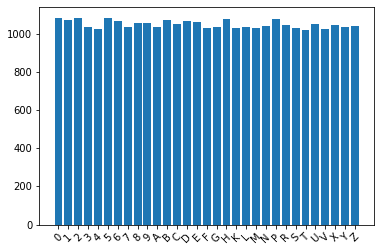

In [5]:
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

def barChart(data):
    """
    Agr:
    - data: type is the dictionary. Keys is the name of class, values is the numbers of elements in class.
    Return:
    - Bar chart of data
    """
    x_pos = [i for i, _ in enumerate(data.keys())]
    plt.bar(x_pos, data.values())
    plt.xticks(x_pos, data.keys(), rotation = 45)
    plt.show()
    
base_dir = '/content/drive/My Drive/ANPR'
raw_data = os.path.join(base_dir, 'dataset_characters')
characters = os.listdir(raw_data)
num_of_each_character = {}
for character in characters:
    character_dir = os.path.join(raw_data, character)
    num = os.listdir(character_dir)
    num_of_each_character[character] = len(num)
    
barChart(num_of_each_character)

In [6]:
!ls /content/drive/MyDrive/ANPR/local_utils.py

/content/drive/MyDrive/ANPR/local_utils.py


In [7]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

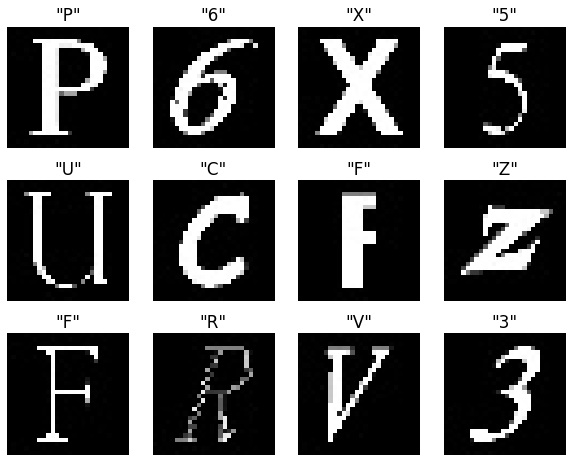

In [8]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)

In [9]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

[INFO] Find 32543 images with 31 classes


In [10]:
# split 20% of data as test set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
# split 20% of data as validation set
(trainX, validationX, trainY, validationY) = train_test_split(trainX, trainY, test_size=0.25, stratify=trainY, random_state=42)

In [19]:
print("TRAIN SET: ", len(trainX), "images with 31 classes")
if len(trainY) == len(trainX):
  print("True\n")

print("TEST SET: ", len(testX), "images with 31 classes")
if len(testY) == len(testX):
  print("True\n")

print("VALIDATION SET: ", len(validationX), "images with 31 classes")
if len(validationY) == len(validationX):
  print("True\n")

TRAIN SET:  19525 images with 31 classes
True

TEST SET:  6509 images with 31 classes
True

VALIDATION SET:  6509 images with 31 classes
True



In [20]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )


In [21]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [22]:
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

9412608/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
305/305 [==============================] - 74s 126ms/step - loss: 1.8788 - accuracy: 0.4964 - val_loss: 2.6658 - val_accuracy: 0.4148

Epoch 00001: saving model to License_character_recognition.h5
Epoch 2/30
305/305 [==============================] - 36s 119ms/step - loss: 0.5312 - accuracy: 0.8596 - val_loss: 1.0486 - val_accuracy: 0.7152

Epoch 00002: saving model to License_character_recognition.h5
Epoch 3/30
305/305 [==============================] - 36s 119ms/step - loss: 0.3352 - accuracy: 0.9133 - val_loss: 0.4032 - val_accuracy: 0.8998

Epoch 00003: saving model to License_character_recognition.h5
Epoch 4/30
305/305 [==============================] - 36s 119ms/step - loss: 0.2502 - accuracy: 0.9331 - val_loss: 0.2943 - val_accuracy: 0.9290

Epoch 00004: saving model to License_character_recognition.h5
Epoch 5/30
305/305 [==============================] - 39s 128ms/step - loss: 0.2161 - accuracy: 0.9442 - val_loss: 0.1863 - val_accuracy: 0.9516

Epoch 00005: saving mo

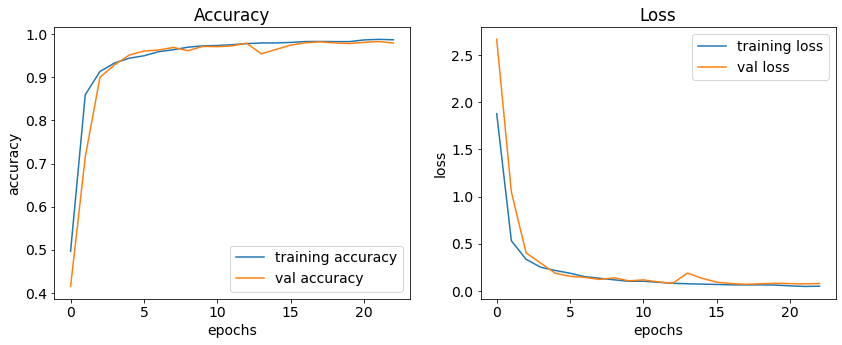

In [24]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig("Training_result.jpg",dpi=300)

In [25]:
# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition.json", "w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib.pyplot import figure
%matplotlib inline
def draw_heatmap_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    classes.sort()
    figure(figsize=(14, 14), dpi=80)
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)

    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    thresol = cm.max()*0.7 + cm.min()*0.3
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[0])):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresol else "black")
    
    plt.colorbar()

    plt.title("Confusion matrix")
    plt.ylabel("True lable", rotation = 90)
    plt.xlabel("Predict lable")

In [56]:
Y_true = testY
Y_true=np.argmax(Y_true, axis=1)
Y_pred = model.predict(testX, steps = len(testX) // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       217
           1       0.99      1.00      0.99       215
           2       0.98      1.00      0.99       217
           3       1.00      0.99      0.99       207
           4       0.99      0.98      0.99       205
           5       0.99      0.99      0.99       217
           6       1.00      0.99      0.99       214
           7       0.98      1.00      0.99       208
           8       1.00      1.00      1.00       211
           9       1.00      1.00      1.00       211
           A       0.99      0.98      0.98       207
           B       0.99      0.96      0.98       214
           C       0.98      0.97      0.98       210
           D       0.98      0.97      0.97       214
           E       0.96      0.98      0.97       213
           F       0.99      1.00      0.99       206
           G       0.96      0.98      0.97       207
     

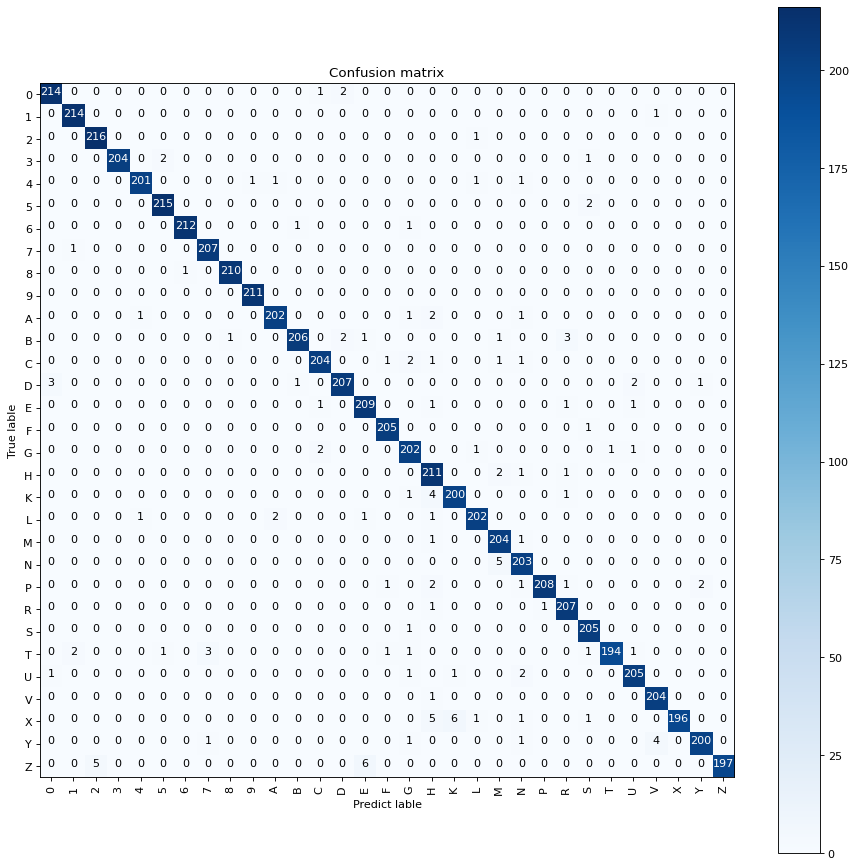

In [65]:
base_dir = '/content/drive/My Drive/ANPR'
evaluation_dir = os.path.join(base_dir, 'dataset_characters')
target_names = os.listdir(evaluation_dir)
draw_heatmap_confusion_matrix(Y_true, y_pred, target_names)
print('Classification Report')
print(classification_report(Y_true, y_pred, target_names=target_names))